# Visualisations 

In [62]:
import math
from typing import List

import scipy
import scipy.sparse
from sklearn.neighbors import NearestNeighbors
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

# plt.style.use('seaborn-v0_8-paper')
plt.style.use('ggplot')

# plt.style.available

# Kernel Visualisation

In [63]:
# KERNELS
def rbf(distance, variance):
    return math.exp(- (distance**2) / (2 * variance))

def laplacian(distance,variance):
    return math.exp(- (distance) / (math.sqrt(variance)))



def sigmoid_kernel(x, y, gamma: float = 1.0, coef0: float = 0.0) -> float:
    # Needs γ and c inside 'nice' ranges to stay in the valid kernel regime.
    x, y = np.asarray(x), np.asarray(y)
    return math.tanh(gamma * float(np.dot(x, y)) + coef0)

def chi2(distance, gamma):
    # Implemented using distance instead of vectors
    return math.exp(-gamma * distance)


# need to access the actual neighbours for these below

# Cosine 
# Polynomial

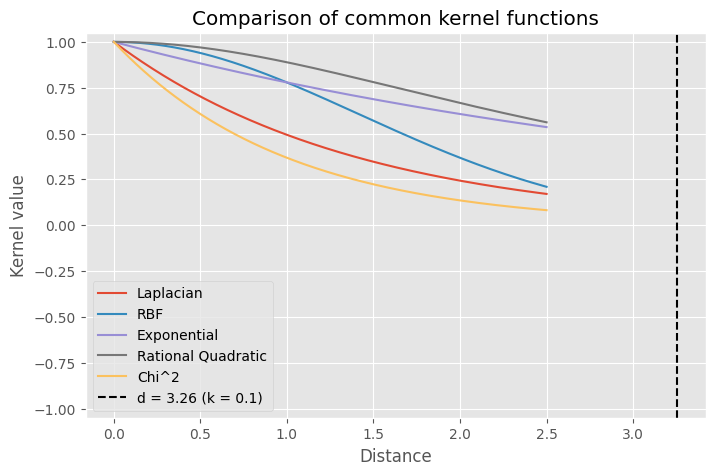

In [64]:
# Distances
d = np.linspace(0.0, 2.5, 500)
# Variance
variance = 2.0          
# alpha     = 1.0           # Rational Quadratic shape
# length_sq = 1.0           # Rational Quadratic ℓ²
# gamma     = 1.0           # chi sq
alpha = 1.0

# Radial kernels
rbf = np.exp(- (d**2) / (2 * variance))
laplacian_vals = np.exp(-d / math.sqrt(variance))
exponential_vals = np.exp(-d / (2 * variance))


rational_quadratic = 1 / (1 + (d**2 / (2 * alpha * variance**2)))
# rq_vals        = (1 + d**2 / 2.0)**-1       # alpha = 1, ℓ = 1
chi2_vals      = np.exp(-d)                 # γ = 1, using χ² distance = d

# Map Euclidean distance → dot product for unit-norm vectors
dot = 1 - d**2 / 2.0                        # ⟨x,y⟩ = cos θ
# sigmoid_vals = np.tanh(dot)                 # γ = 1, c = 0
# cosine_vals  = dot                          # cosine similarity itself

# valid = dot >= -1.0                                # keep sigmoid/cosine valid
# sigmoid_vals = np.where(valid, np.tanh(dot), np.nan)
# cosine_vals  = np.where(valid, dot,       np.nan)



# Plot everything together
plt.figure(figsize=(8, 5))
plt.plot(d, laplacian_vals, label='Laplacian')
plt.plot(d, rbf, label='RBF')
plt.plot(d, exponential_vals, label ='Exponential' )
plt.plot(d, rational_quadratic, label='Rational Quadratic')
plt.plot(d, chi2_vals, label='Chi^2')
# plt.plot(d, sigmoid_vals, label='Sigmoid (tanh)')
# plt.plot(d, cosine_vals, label='Cosine similarity')

# Plot line where laplacian reaches 0.1 since it is the fastest decaying kernel (most of the times)
threshold_val = 0.1
target_d = -math.log(threshold_val) * math.sqrt(variance)


plt.axvline(target_d, linestyle='--', color='k',
            label=f'd = {target_d:.2f} (k = {threshold_val})')

plt.xlabel('Distance')
plt.ylabel('Kernel value')
plt.title('Comparison of common kernel functions')
plt.ylim(-1.05, 1.05)
plt.legend()
plt.grid(True)
plt.show()

# Experiment Visualisations

In [75]:
# Get paths to all the experiment csvs
csv_directory = "results/bsds/csv_results/"
paths = [f for f in os.listdir(csv_directory) if f.endswith('.csv')]
paths.sort()
print(paths)
# paths for FCN
fcn_paths = [f for f in paths if f.startswith("01")]
fcn_paths.sort()
print(fcn_paths)
# paths for KNN
knn_paths = [str(f) for f in paths if f.startswith("KNN")]
knn_paths.sort()
print(knn_paths)

['01_0_FCN_rbf.csv', '01_1_FCN_rbf.csv', '01_2_FCN_rbf.csv', '01_3_FCN_rbf.csv', '01_4_FCN_rbf.csv', '02_0_FCN_laplacian.csv', '02_1_FCN_laplacian.csv', 'KNN_01.csv', 'KNN_02.csv', 'KNN_03.csv', 'KNN_04.csv', 'KNN_05.csv']
['01_0_FCN_rbf.csv', '01_1_FCN_rbf.csv', '01_2_FCN_rbf.csv', '01_3_FCN_rbf.csv', '01_4_FCN_rbf.csv']
['KNN_01.csv', 'KNN_02.csv', 'KNN_03.csv', 'KNN_04.csv', 'KNN_05.csv']


### RBF Kernel with different variances

In [66]:
# Read csvs of experiments with rbf kernel into pd dataframe
fcn_rbf_10 = pd.read_csv("results/bsds/csv_results/01_0_FCN_rbf.csv")
fcn_rbf_20 = pd.read_csv("results/bsds/csv_results/01_1_FCN_rbf.csv")
fcn_rbf_50 = pd.read_csv("results/bsds/csv_results/01_2_FCN_rbf.csv")
fcn_rbf_100 = pd.read_csv("results/bsds/csv_results/01_3_FCN_rbf.csv")
fcn_rbf_200 = pd.read_csv("results/bsds/csv_results/01_4_FCN_rbf.csv")


variance_mapping = [10, 20, 50, 100, 200]


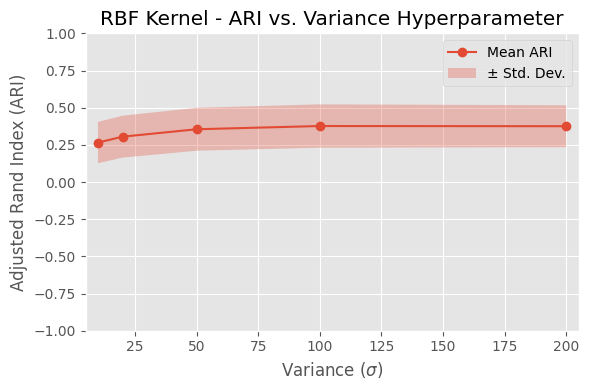

In [67]:
# Plot average ri per variance value


# average = {
#     '10':  fcn_rbf_10['ri'].mean(),
#     '20':  fcn_rbf_20['ri'].mean(),
#     '50':  fcn_rbf_50['ri'].mean(),
#     '100': fcn_rbf_100['ri'].mean(),
#     '200': fcn_rbf_100['ri'].mean(),
# }

sigmas = []
means = []
stdevs = []

for fileName in fcn_paths: 
    index = int(fileName.split("_")[1])
    sigma = variance_mapping[index]

    df = pd.read_csv(csv_directory + fileName)
    sigmas.append(sigma)
    means.append(df['ri'].mean())
    stdevs.append(df['ri'].std())


# Sort by sigma
# sigmas, means, stdevs = zip(sigmas, means, stdevs)

# --- STEP 3: plot ---
plt.figure(figsize=(6,4))
plt.plot(sigmas, means, marker='o', label='Mean ARI')
plt.fill_between(
    sigmas,
    [m-s for m, s in zip(means, stdevs)],
    [m+s for m, s in zip(means, stdevs)],
    alpha=0.3,
    label='± Std. Dev.'
)
plt.xlabel('Variance ($\sigma$)')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.ylim(-1,1)
plt.xlim(5,205)
plt.title('RBF Kernel - ARI vs. Variance Hyperparameter')
plt.legend()
plt.tight_layout()
plt.show()


## KNN with diff k

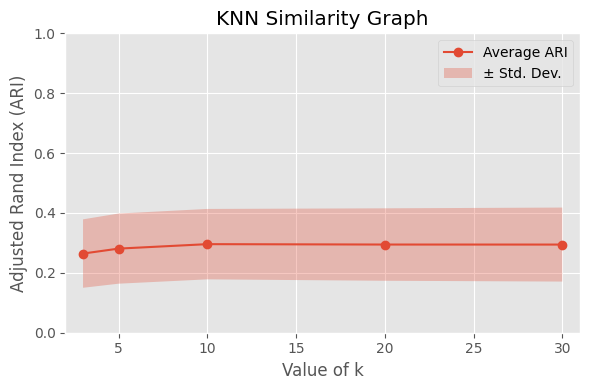

In [68]:
k_values = []
means = []
stdevs = []

triples = []

# knn_mapping = [0, 5, 10 ,20 ,30, 3, 15, 25]
knn_mapping = [0, 5, 10 ,20 ,30, 3]

for fileName in knn_paths: 
    index = int(fileName.split("_")[1][1])
    k = knn_mapping[index]

    df = pd.read_csv(csv_directory + fileName)
    k_values.append(k)
    means.append(df['ri'].mean())
    stdevs.append(df['ri'].std())
    mean_ri = df['ri'].mean()
    std_ri  = df['ri'].std()
    triples.append((k, mean_ri, std_ri))


# Sort by k_values
# sigmas, means, stdevs = zip(sigmas, means, stdevs)
    

# Sort by k
triples_sorted = sorted(triples, key=lambda t: t[0])
ks, means, stdevs = zip(*triples_sorted)

# --- STEP 3: plot ---
plt.figure(figsize=(6,4))
plt.plot(ks, means, marker='o', label='Average ARI')
plt.fill_between(
    ks,
    [m-s for m, s in zip(means, stdevs)],
    [m+s for m, s in zip(means, stdevs)],
    alpha=0.3,
    label='± Std. Dev.'
)
plt.xlabel('Value of k')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.ylim(0,1)
plt.xlim(2,max(knn_mapping)+1)
plt.title('KNN Similarity Graph')
plt.legend()
plt.tight_layout()
plt.show()


### Metric vs # Clusters for each experiment

#### ARI vs # Clusters

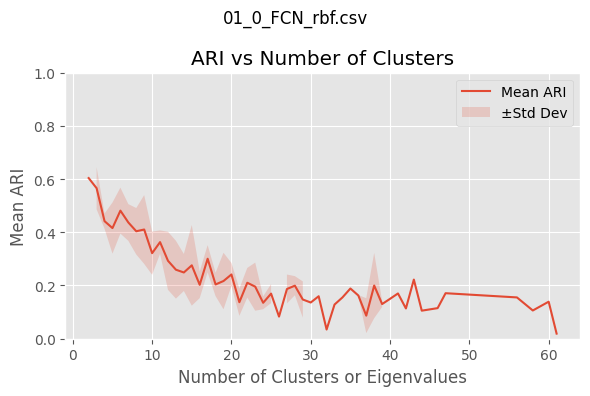

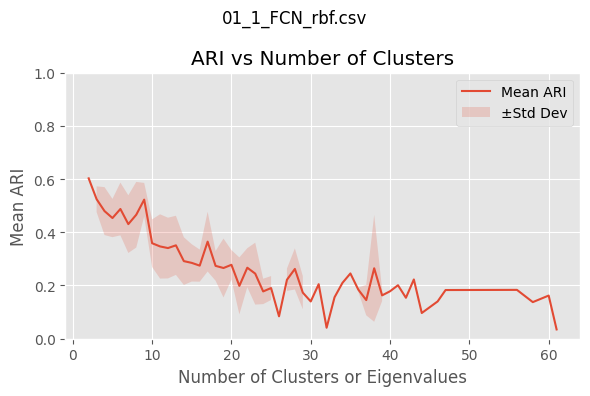

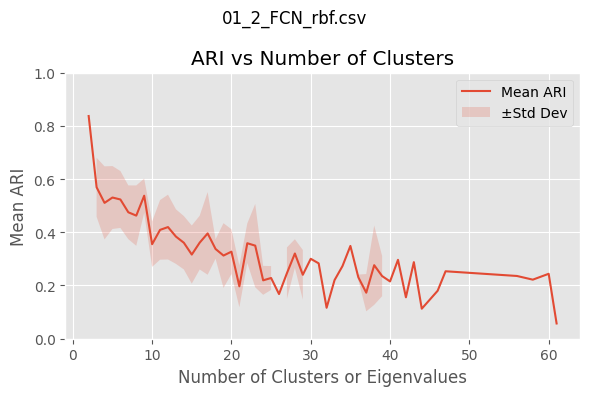

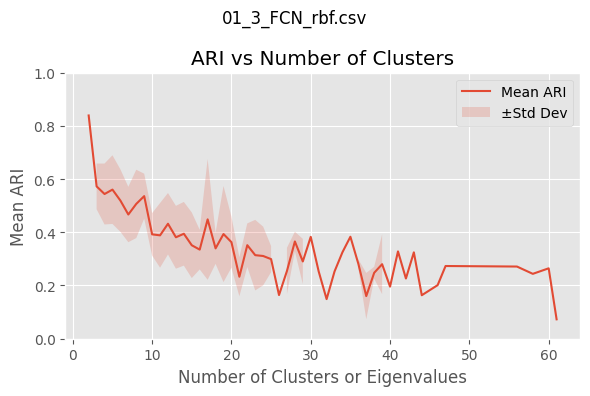

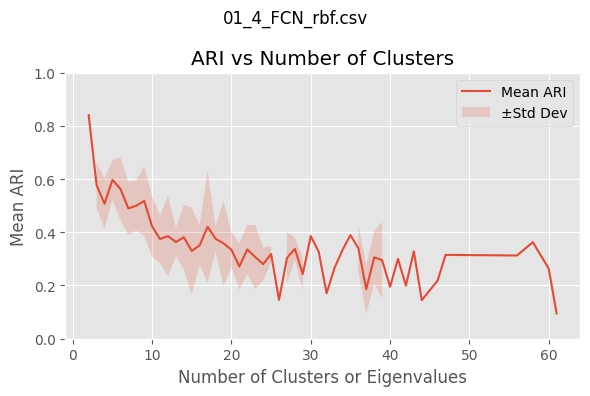

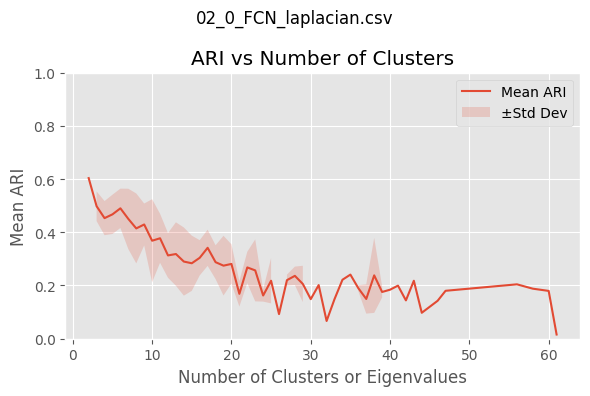

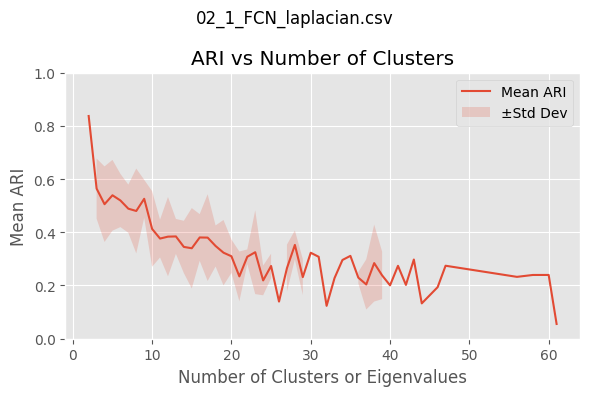

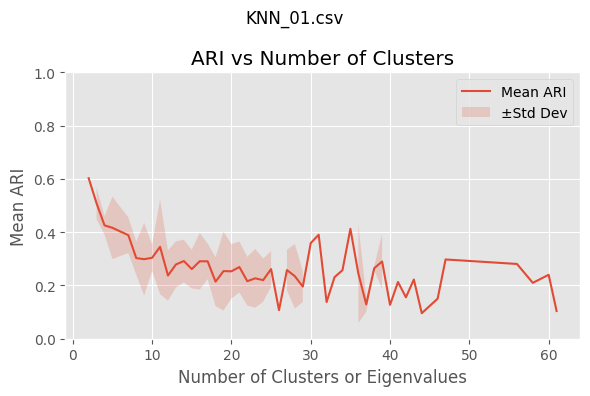

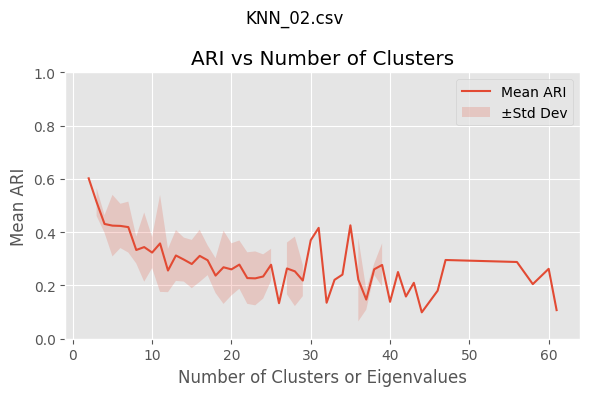

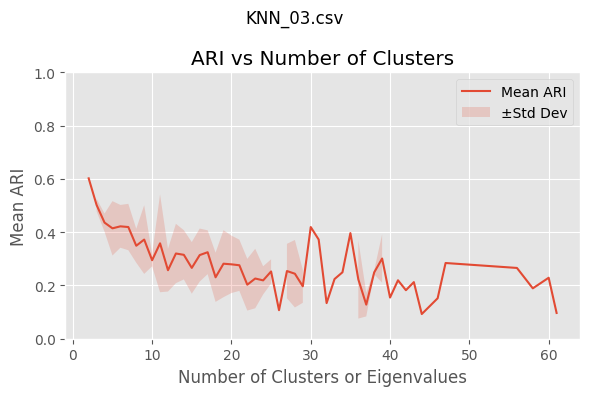

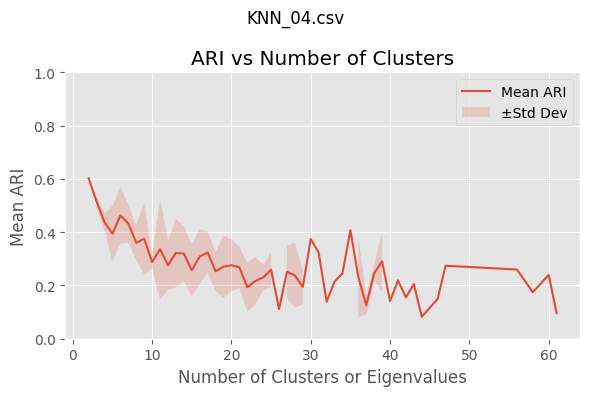

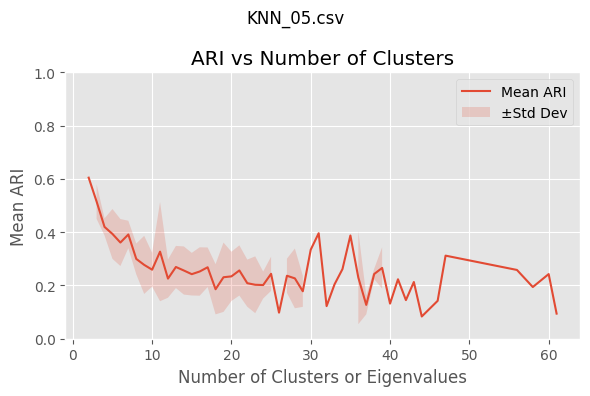

In [69]:
# paths = ["results/bsds/csv_results/01_0_FCN_rbf.csv"]

for path in paths: 
    data = pd.read_csv(csv_directory + path)
    stats = data.groupby('eigs')['ri'].agg(['mean', 'std']).reset_index()

    x = stats['eigs']
    y = stats['mean']
    yerr = stats['std']

    plt.figure(figsize=(6,4))
    plt.suptitle(path)
    plt.plot(x, y, label='Mean ARI')
    plt.fill_between(x, y - yerr, y + yerr, alpha=0.2, label='±Std Dev')
    plt.xlabel('Number of Clusters or Eigenvalues')
    plt.ylabel('Mean ARI')
    plt.title('ARI vs Number of Clusters')
    plt.legend()
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

#### ARI vs # Clusters for all tests (overlaid)

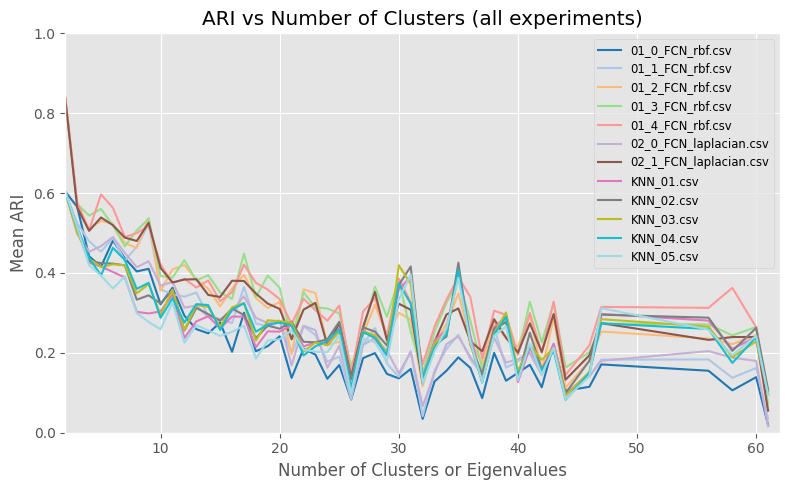

In [70]:
plt.figure(figsize=(8,5))

cmap = plt.get_cmap('tab20', len(paths)) 

for i, fileName in enumerate(paths): 
    data = pd.read_csv(csv_directory + fileName)
    stats = data.groupby('eigs')['ri'].agg(['mean', 'std']).reset_index()

    x = stats['eigs']
    y = stats['mean']
    yerr = stats['std']

    # plt.plot(x, y, marker='o', label=fileName)
    plt.plot(x, y, label=fileName, color = cmap(i))
    # plt.fill_between(x,
    #                  y - yerr,
    #                  y + yerr,
    #                  alpha=0.2)


# plt.suptitle(fileName)
# plt.plot(x, y, label='Mean ARI')
# plt.fill_between(x, y - yerr, y + yerr, alpha=0.2, label='±Std Dev')
plt.xlabel('Number of Clusters or Eigenvalues')
plt.ylabel('Mean ARI')
plt.title('ARI vs Number of Clusters (all experiments)')
plt.legend(fontsize = 'small')
plt.ylim(0,1)
plt.xlim(2,62)
plt.tight_layout()
plt.show()

#### VOI vs # Clusters

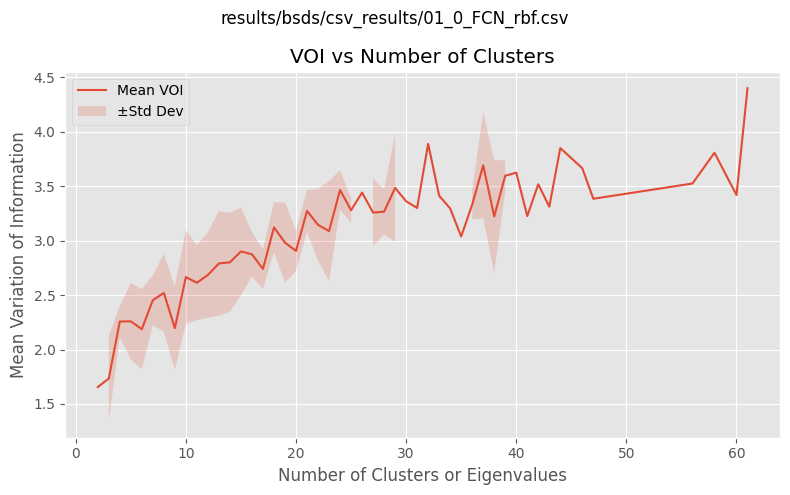

In [71]:
paths = ["results/bsds/csv_results/01_0_FCN_rbf.csv"]

for path in paths: 
    data = pd.read_csv(path)
    stats = data.groupby('eigs')['voi'].agg(['mean', 'std']).reset_index()

    x = stats['eigs']
    y = stats['mean']
    yerr = stats['std']

    plt.figure(figsize=(8,5))
    plt.suptitle(path)
    plt.plot(x, y, label='Mean VOI')
    plt.fill_between(x, y - yerr, y + yerr, alpha=0.2, label='±Std Dev')
    plt.xlabel('Number of Clusters or Eigenvalues')
    plt.ylabel('Mean Variation of Information')
    plt.title('VOI vs Number of Clusters')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Kernel Metrics Comparison Table

In [79]:
comparison = pd.DataFrame(columns=['ExperimentName', 'ARI avg', 'ARI stdev', 'Max ARI', 'Min ARI' , 'VOI avg', 'VOI stdev' ])
rows = []
for fileName in paths: 
    df = pd.read_csv(csv_directory + fileName)
    rows.append({
        'ExperimentName': fileName,
        'ARI avg':   df['ri'].mean(),
        'ARI stdev': df['ri'].std(),
        'Max ARI': df['ri'].max(),
        'Min ARI': df['ri'].min(),
        'VOI avg':   df['voi'].mean(),
        'VOI stdev': df['voi'].std()
    })

comparison = pd.DataFrame(rows,
                          columns=['ExperimentName', 'ARI avg', 'ARI stdev', 'Max ARI', 'Min ARI' , 'VOI avg', 'VOI stdev' ])
print(comparison)

            ExperimentName   ARI avg  ARI stdev   Max ARI   Min ARI   VOI avg  \
0         01_0_FCN_rbf.csv  0.265449   0.138966  0.645204  0.008885  2.909016   
1         01_1_FCN_rbf.csv  0.305003   0.140796  0.609245  0.034950  2.727371   
2         01_2_FCN_rbf.csv  0.354847   0.144379  0.836795  0.057291  2.571231   
3         01_3_FCN_rbf.csv  0.376655   0.145792  0.838881  0.059281  2.544419   
4         01_4_FCN_rbf.csv  0.375363   0.141020  0.839917  0.070840  2.604142   
5   02_0_FCN_laplacian.csv  0.299559   0.132585  0.619631  0.015795  2.726694   
6   02_1_FCN_laplacian.csv  0.356957   0.144297  0.836873  0.055444  2.571730   
7               KNN_01.csv  0.280938   0.117166  0.735565  0.040062  2.804593   
8               KNN_02.csv  0.295847   0.117592  0.764264  0.065666  2.749692   
9               KNN_03.csv  0.294538   0.120971  0.745914  0.067794  2.793872   
10              KNN_04.csv  0.294455   0.123596  0.752405  0.071955  2.819658   
11              KNN_05.csv  